# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Solutions to Homework 9
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, April 7th, 2018 at 10:59am

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [81]:
import itertools
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from scipy.special import erf

import copy
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("poster")

This Homework is a continuation of Problem #1 from Homework 8.

Your answers to Problem #1 from HW8 should  give you a idea of how one might create or select a model for a particular application and your answers will help you with formalizing the model in this Homework, which is much more technically involved.


## Problem #1: Modeling Your Understanding

In the dataset "reviews_processed.csv", you'll find a database of Yelp reviews for a number of restaurants. These reviews have already been processed and transformed by someone who has completed the (pre) modeling process described in Problem #1. That is, imagine the dataset in "reviews_processed.csv" is the result of feeding the raw Yelp reviews through the pipeline someone built for Problem #1.

The following is a full list of columns in the dataset and their meanings:

I. Relevant to Part A and B:

  1. "review_id" - the unique identifier for each Yelp review
  2. "topic" - the subject addressed by the review (0 stands for food and 1 stands for service)
  3. "rid" - the unique identifier for each restaurant
  4. "count" - the number of sentences in a particular review on a particular topic
  5. "mean" - the probability of a sentence in a particular review on a particular topic being positive, averaged over total number of sentences in the review related to that topic.
  6. "var" - the variance of the probability of a sentence in a particular review on a particular topic being positive, taken over all sentences in the review related to that topic.

II. Relevant (possibly) to Extra Credit:

  1. "uavg" - the average star rating given by a particular reviewer (taken across all their reviews)
  2. "stars" - the number of stars given in a particular review
  3. "max" - the max probability of a sentence in a particular review on a particular topic being positive
  4. "min" - the min probability of a sentence in a particular review on a particular topic being positive

The following schema illustrates the model of the raw data that is used to generate "reviews_processed.csv":
<img src="restuarant_model.pdf">

***Warning:*** *this is a "real" data science problem in the sense that the dataset in "reviews_processed.csv" is large. We understand that a number of you have limited computing resources, so you are encouraged but not required to use the entire dataset. If you wish you may use 10 restaurants from the dataset, as long as your choice of 10 contains a couple of restaurants with a large number of reviews and a couple with a small number of reviews.*

### Part A: Modeling

When the value in "count" is low, the "mean" value can be very skewed.

Following the [SAT prep school example discussed in lab](https://am207.github.io/2018spring/wiki/gelmanschoolstheory.html) (and using your answers for HW 8 Problem #1), set up a Bayesian model(that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service, separately. That is, you will have a model for each restaurant and each aspect (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

**Hint:** what quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?

**Solution**:

Adapting the prep school example, i.e. the Gelman/Rubin Schools (GRS) model, we can draw a correspondence between the aspects of our review data and the corresponding attribute in GRS.  There seems to be an obvious isomorphism between $\bar{y}_j$ in GRS and the mean "positive sentiment" in individual reviews. A similar correspondence can be drawn from $\sigma_j^2$ in GRS to the standard error on our mean positive sentiment, given by the variance field divided by the count field. 

Our formal definition of our model for the 10 selected restaurants is as follows.  Given $k$  an index over restaurants, $j$ an index over reviewers, and $t$ indicate one of the two topics (food and service). 

\begin{align*}
\mu^t_k &\sim \mathcal{N}(0.5, 0.15) \\
\tau^t_k &\sim \mathrm{Half-Cauchy}(0, 0.1) \\
\nu_j^t &\sim \mathcal{N}(0, 0.5) \\
\theta_{jk}^t &= \mu + \tau\nu_j \\
\bar{y}_{jk}^t &\sim \mathcal{N}(\theta_j, \sigma_j)
\end{align*}

We will fit the above model to our selected restaurants.

---

## Read data

In [5]:
review_data = pd.read_csv('reviews_processed.csv')
review_data.head()

,review_id,topic,rid,count,max,mean,min,stars,uavg,var
0,---sV8KdwfBoDw38KW_WnQ,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.689383,0.558430,0.312919,3,3.285714,0.024112
1,---sV8KdwfBoDw38KW_WnQ,1,VgLiSW1iGkpzIEXOgvUBEw,5,0.816901,0.554300,0.211441,3,3.285714,0.050309
2,--0MzHNy7MVBRvZCOAeRPg,0,4gLecengX1JeGILm7DwU3w,3,0.746711,0.574416,0.360240,5,3.829268,0.038655
3,--0MzHNy7MVBRvZCOAeRPg,1,4gLecengX1JeGILm7DwU3w,6,0.848065,0.657755,0.476156,5,3.829268,0.014583
4,--2NT40xmHh9oBLumzdjhA,0,4ZZab5hinFzHtj3sE8vQWg,5,0.764218,0.601008,0.337710,2,4.181818,0.026742


--- 
## Pick the first restaurant, get all the reviews for food

In [163]:
restaurant_food = review_data[(review_data['rid'] == 'VgLiSW1iGkpzIEXOgvUBEw') & (review_data['topic'] == 0)]
restaurant_service = review_data[(review_data['rid'] == 'VgLiSW1iGkpzIEXOgvUBEw') & (review_data['topic'] == 1)]
restaurant_food = restaurant_food[restaurant_food['count'] > 1]
restaurant_food

,review_id,topic,rid,count,max,mean,min,stars,uavg,var
0,---sV8KdwfBoDw38KW_WnQ,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.689383,0.558430,0.312919,3,3.285714,0.024112
16303,600ErYXwcQd6YQdcT_ePFA,0,VgLiSW1iGkpzIEXOgvUBEw,4,0.931213,0.722069,0.409279,5,3.562500,0.050529
22021,8T-d0tPz9_-VNKMuHADAvw,0,VgLiSW1iGkpzIEXOgvUBEw,2,0.640864,0.626300,0.611737,5,4.500000,0.000424
25095,9pLU67EpL2kG59-y1tsgbA,0,VgLiSW1iGkpzIEXOgvUBEw,6,0.793546,0.659759,0.432725,4,3.500000,0.021687
99102,ewHhAbWDSh0pX0JaBS2W4Q,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.951721,0.807200,0.621870,5,4.000000,0.017860
118111,n4sA4WSdX7nCwBffjIzv6Q,0,VgLiSW1iGkpzIEXOgvUBEw,3,0.896948,0.756636,0.557103,5,4.653846,0.031504
119299,nbbrF_A9Sg2lVNFyge5mPg,0,VgLiSW1iGkpzIEXOgvUBEw,2,0.757617,0.752164,0.746711,5,5.000000,0.000059


--- 
## Pick the first restaurant, get all the reviews for service

In [164]:
restaurant_service = restaurant_service[restaurant_service['count'] > 1]
restaurant_service

,review_id,topic,rid,count,max,mean,min,stars,uavg,var
1,---sV8KdwfBoDw38KW_WnQ,1,VgLiSW1iGkpzIEXOgvUBEw,5,0.816901,0.554300,0.211441,3,3.285714,0.050309
16304,600ErYXwcQd6YQdcT_ePFA,1,VgLiSW1iGkpzIEXOgvUBEw,2,0.886099,0.838128,0.790157,5,3.562500,0.004602
22022,8T-d0tPz9_-VNKMuHADAvw,1,VgLiSW1iGkpzIEXOgvUBEw,2,0.747628,0.684997,0.622365,5,4.500000,0.007845


---
## Restaurant 1: Model for Food

In [ ]:
j_obs = restaurant_food.shape[0]
y_obs = restaurant_food['mean'].values
sigma_obs = np.sqrt(restaurant_food['var'].values / restaurant_food['count'].values)

In [25]:
with pm.Model() as alt_food_model:
    mu = pm.Normal('mu', mu = 0.5, sd = 0.15)
    tau = pm.HalfCauchy('tau', beta = 0.1)
    nu = pm.Normal('nu', mu = 0, sd = 0.5, shape = j_obs)
    theta = pm.Deterministic('theta', mu + tau * nu)
    obs = pm.Normal('obs', mu = theta, sd = sigma_obs, observed = y_obs)

In [ ]:
with alt_food_model:
        alt_food_trace = pm.sample(20000, init=None, tune=2000)

In [ ]:
j_obs = restaurant_food.shape[0]
y_obs = restaurant_food['mean'].values
sigma_obs = np.sqrt(restaurant_food['var'].values / restaurant_food['count'].values)

In [25]:
with pm.Model() as rest1_food_model:
    mu = pm.Normal('mu', mu = 0.5, sd = 0.15)
    tau = pm.HalfCauchy('tau', beta = 0.1)
    nu = pm.Normal('nu', mu = 0, sd = 0.5, shape = j_obs)
    theta = pm.Deterministic('theta', mu + tau * nu)
    obs = pm.Normal('obs', mu = theta, sd = sigma_obs, observed = y_obs)

In [ ]:
with rest1_food_model:
        rest1_food_trace = pm.sample(20000, init=None, tune=2000)

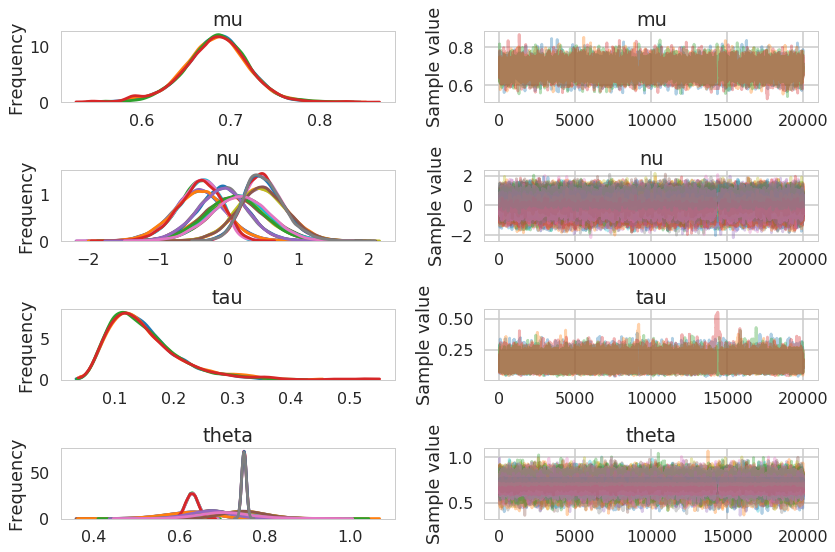

In [171]:
pm.traceplot(rest1_food_trace);

---
## Restaurant 1: Model for Service

In [ ]:
j_obs = restaurant_service.shape[0]
y_obs = restaurant_service['mean'].values
sigma_obs = np.sqrt(restaurant_service['var'].values / restaurant_service['count'].values)

In [ ]:
with pm.Model() as rest1_service_model:
    mu = pm.Normal('mu', mu = 0.5, sd = 0.15)
    tau = pm.HalfCauchy('tau', beta = 0.1)
    nu = pm.Normal('nu', mu = 0, sd = 0.5, shape = j_obs)
    theta = pm.Deterministic('theta', mu + tau * nu)
    obs = pm.Normal('obs', mu = theta, sd = sigma_obs, observed = y_obs)

In [ ]:
with rest1_service_model:
        rest1_service_trace = pm.sample(20000, init=None, tune=3000)

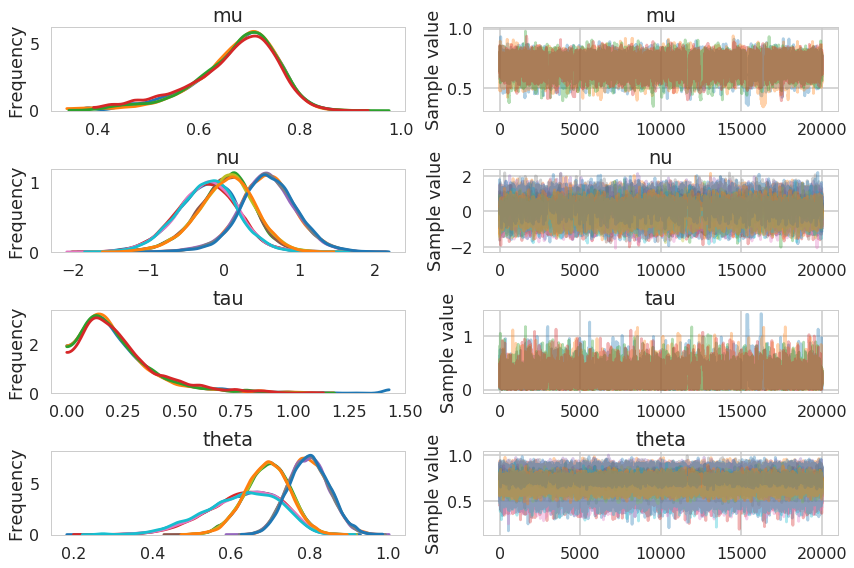

In [29]:
pm.traceplot(rest1_service_trace);

---
## Visualizing Divergence

In [58]:
# Number of divergent samples
divergent_traces = rest1_service_trace['diverging']
print('Number of Divergent Traces: %d' % divergent_traces.nonzero()[0].size)
divergent_percentage = divergent_traces.nonzero()[0].size/len(rest1_food_trace)
print('Percentage of Divergent Traces: %.5f' % divergent_percentage)

Number of Divergent Traces: 1926
Percentage of Divergent Traces: 0.09630


Only a small fraction of our samples are divergent samples.  Let's visualize them.

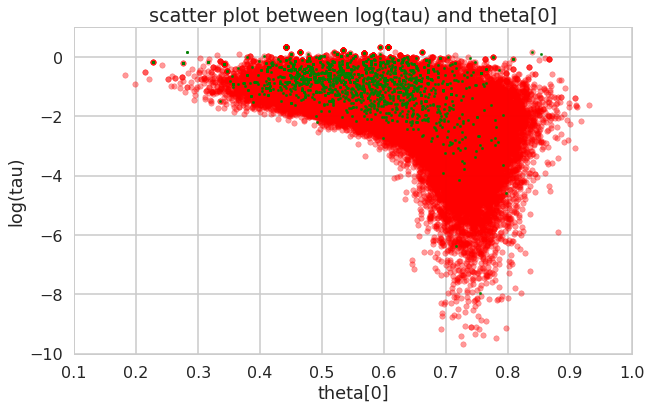

In [65]:
theta_trace = rest1_service_trace['theta']
logtau_trace = rest1_service_trace['tau_log__']
theta0 = theta_trace[:, 0]

plt.figure(figsize=(10, 6))
plt.scatter(theta0[divergent_traces == 0], logtau_trace[divergent_traces == 0], color='r', alpha=0.4, s=30)
plt.scatter(theta0[divergent_traces == 1], logtau_trace[divergent_traces == 1], color='g', s=5)
plt.axis([0.1, 1.0, -10, 1])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')
plt.show()

While we have a number of divergences, they don't seem to be overly localized suggesting that we may have some misidentification going on (although they maybe localized enough to warrant further investigation)

### Part B: Analysis for Each restaurant

Use your model to produce estimates for $\theta_{jk}$'s. Pick a few restaurants, for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

For the same restaurants, for each aspect, generate shrinkage plots and probability shrinkage plots as follows:

**Shrinkage plot for a restaurant, topic**:

The aim for this plot is to see the shrinkage from sample means (error bars generated from standard error) to $\theta_{jk}$'s (error bars generated from theta variance).  

The sample means of reviews are plotted at $y=0$ and the posterior means ($\theta_{ik}$) are plotted at $y=1$. For each review connect the sample mean to the posterior mean with a line.  Show error bars on the sample mean points using standard error and on the ($\theta_{jk}$) points using variance.

**Probability Shrinkage plot for a restaurant, topic**:

The aim for this plot is to see the shrinkage from the classification probabilities from the sample means of reviews to the classification probabilities of $\theta_{jk}$'s.  The classification probabilities are calculated from the gaussian at the given mean and variance. The sample means and standard error are fed into the gaussian to generate one set of classification probabilities.  The $\theta_{jk}$ estimates and variances are fed into the gaussian to generate the other set of variances.

The y values are the classification probability (calculated as 1-cdf) using the normal distribution at a given mean and variance.

The sample means of reviews are plotted with $y$'s obtained by using the sample means as the means in the normal above, with line segments (error bars) representing the standard error. 

The posterior means ($\theta_{jk}$) are plotted with $y$'s obtained using the posterior means (thetas) in the gaussian above, and variances on the thetas with line segments (error bars) representing the variances on the $\theta_{jk}$'s.

We've provided you some code to generate a shrinkage plot and a probability shrinkage plot is included in this notebook, but feel free to implement your own. The code should also help elucidate the text above.

Use these plots to discuss the statistical benefits of modeling each reviewer's opinion using your model from Part A, rather than approximating the reviewer opinion with the value in "mean".

Example of a shrinkage plot:
<img src="shrinkage.png">

Example of a probability shrinkage plot:
<img src="shrinkage_prob.png">

**Solutions**

In [154]:
import itertools

# Use 1-cdf at 0.5 to model the probability of having positive sentiment
# it basically tells you the area under the gaussian after 0.5 (we'll assume 
# positive sentiment based on the usual probability > 0.5 criterion)

prob = lambda mu, vari: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari)))

# fix a restaurant and an aspect (food or service)
# "means" is the array of values in the "mean" column for the restaurant and the aspect 
#         in the dataset
# "thetas" is the array of values representing your estimate of the opinions of reviewers 
#          regarding this aspect of this particular restaurant
# "theta_vars" is the array of values of the varaiances of the thetas
# "counts" is the array of values in the "count" column for the restaurant and the aspect 
#.         in the dataset
# FEEL FREE TO RE-IMPLEMENT THESE

def shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=0) shrink to
    review $theta$s, plotted at y=1
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)   
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color=next(palette)
            # add some jitter to y values to separate them
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            if me==0:
                me = 4
            # plot shrinkage line from mean, 0 to
            # theta, 1. Also plot error bars
            ax.plot([m,t],[noise,1+noise2],'o-', color=color, lw=1)
            ax.errorbar([m,t],[noise,1+noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color,  lw=1)
        ax.set_yticks([])
        ax.set_xlim([0,1])
        sns.despine(offset=-2, trim=True, left=True)
    return plt.gca()

def prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=prob(mean)) shrink to
    review $theta$s, plotted at y=prob(theta)
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color = next(palette)
            # add some jitter to y values to separate them
            noise = 0.001 * np.random.randn()
            noise2 = 0.001 * np.random.randn()
            if me == 0: #make mean error super large if estimated as 0 due to count=1
                me = 4
            p = prob(m, me)
            peb = prob(t, te)
            # plot shrinkage line from mean, prob-based_on-mean to
            # theta, prob-based_on-theta. Also plot error bars
            ax.plot([m, t],[p, peb],'o-', color=color, lw=1)
            ax.errorbar([m, t],[p + noise, peb + noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color, lw=1)
        ax = plt.gca()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
    return ax

#### Select Restaurants and Store Data

In [175]:
restaurant_food = review_data[(review_data['rid'] == 'VgLiSW1iGkpzIEXOgvUBEw') & (review_data['topic'] == 0)]
restaurant_service = review_data[(review_data['rid'] == 'VgLiSW1iGkpzIEXOgvUBEw') & (review_data['topic'] == 1)]
restaurant_food = restaurant_food[restaurant_food['count'] > 1]
restaurant_food

rids = np.unique(np.array(review_data['rid']))
np.random.seed(433) 
rids_sample = np.random.choice(rids, size=10, replace=False)

restaurants = []

for i,rid in enumerate(rids_sample):
    restaurant_food = review_data[(review_data['rid'] == rid) & (review_data['topic'] == 0)]
    restaurant_service = review_data[(review_data['rid'] == rid) & (review_data['topic'] == 1)]
    restaurant_food = restaurant_food[restaurant_food['count'] > 1]
    restaurant_service = restaurant_service[restaurant_service['count'] > 1]

    rest_food = {}
    rest_service = {}
    
    rest_food['j_obs'] = restaurant_food.shape[0]
    rest_food['y_obs'] = restaurant_food['mean'].values
    rest_food['sigma_obs'] = np.sqrt(restaurant_food['var'].values / restaurant_food['count'].values)
    rest_food['count_obs'] = restaurant_food['count'].values
    
    rest_service['j_obs'] = restaurant_service.shape[0]
    rest_service['y_obs'] = restaurant_service['mean'].values
    rest_service['sigma_obs'] = np.sqrt(restaurant_service['var'].values / restaurant_service['count'].values)
    rest_service['count_obs'] = restaurant_service['count'].values
    
    restaurants.append((rest_food, rest_service))


In [135]:
print("Food reviews by restaurant:   ", [restaurant[0]['j_obs'] for restaurant in restaurants])
print("Service reviews by restaurant:", [restaurant[1]['j_obs'] for restaurant in restaurants])

Food reviews by restaurant:    [7, 6, 7, 6, 7, 3, 7, 6, 6, 6]
Service reviews by restaurant: [6, 2, 5, 8, 7, 2, 5, 2, 3, 3]


#### Run Models and Store Traces

In [ ]:
restaurant_traces = []
for restaurant in restaurants:
    trace = []
    
    for topic in restaurant:
        with pm.Model() as rest_model:
            mu = pm.Normal('mu', mu = 0.5, sd = 0.15)
            tau = pm.HalfCauchy('tau', beta = 0.1)
            nu = pm.Normal('nu', mu = 0, sd = 0.5, shape = topic['j_obs'])
            theta = pm.Deterministic('theta', mu + tau * nu)
            obs = pm.Normal('obs', mu = theta, sd = topic['sigma_obs'], observed = topic['y_obs'])

            rest_trace = pm.sample(20000, init=None, tune=3000)
        
        trace.append(copy.deepcopy(rest_trace))
        
    restaurant_traces.append(trace)
    

In [184]:
import pickle

with open("restaurants2.txt", "wb") as fp:   #pickling
    pickle.dump(restaurant_traces,fp)

In [98]:
with open("restaurants.txt", "rb") as fp:   #unpickling
    restaurants2 = pickle.load(fp)

#### Restaurant 1 Food Reviews Traceplot

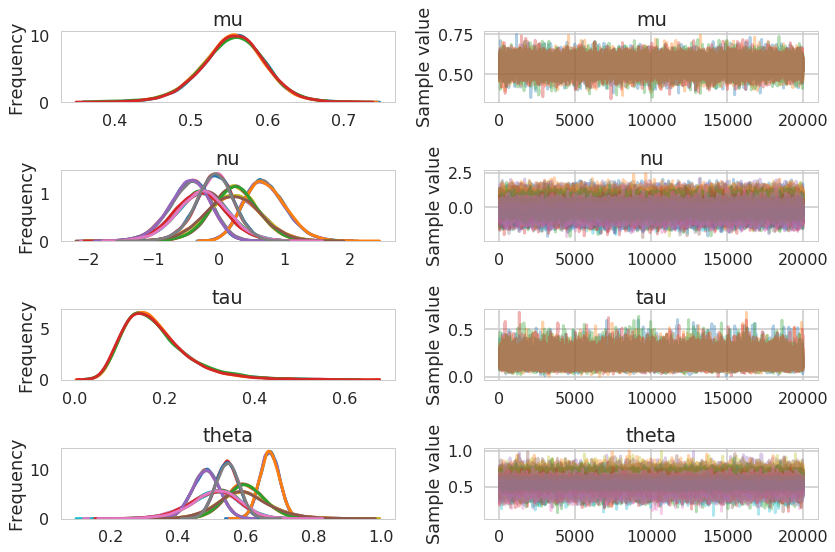

In [101]:
pm.traceplot(restaurant_traces[0][0]);

#### Restaurant 1 Service Reviews Traceplot

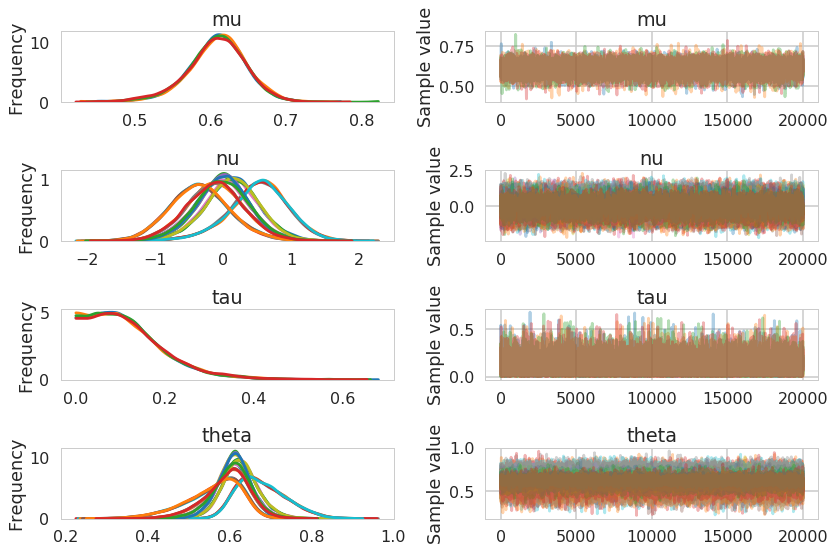

In [102]:
pm.traceplot(restaurant_traces[0][1]);

#### Restaurant 2 Food Reviews Traceplot

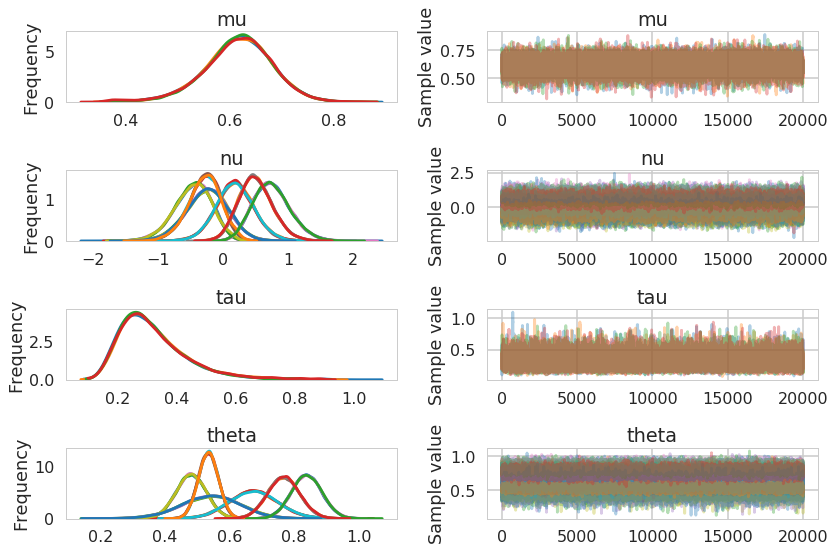

In [159]:
pm.traceplot(restaurant_traces[1][0]);

#### Restaurant 2 Service Reviews Traceplot

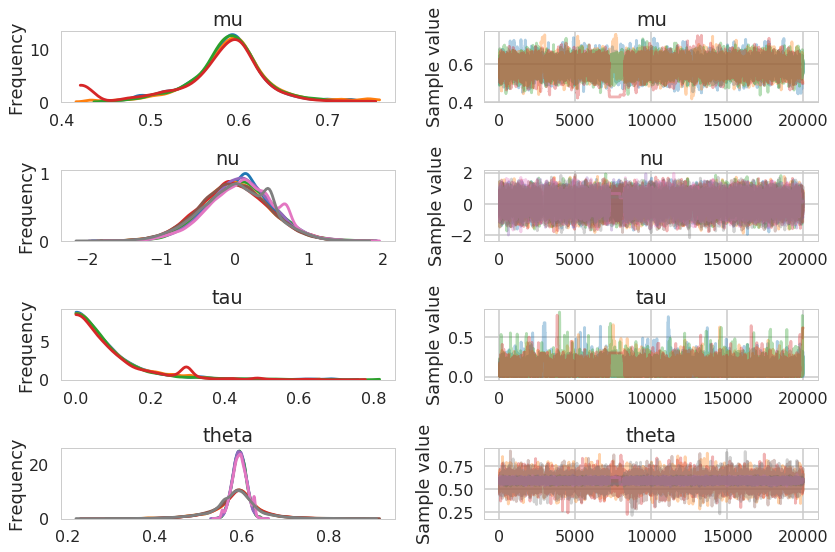

In [158]:
pm.traceplot(restaurant_traces[1][1]);

#### Food Shrinkage Plots

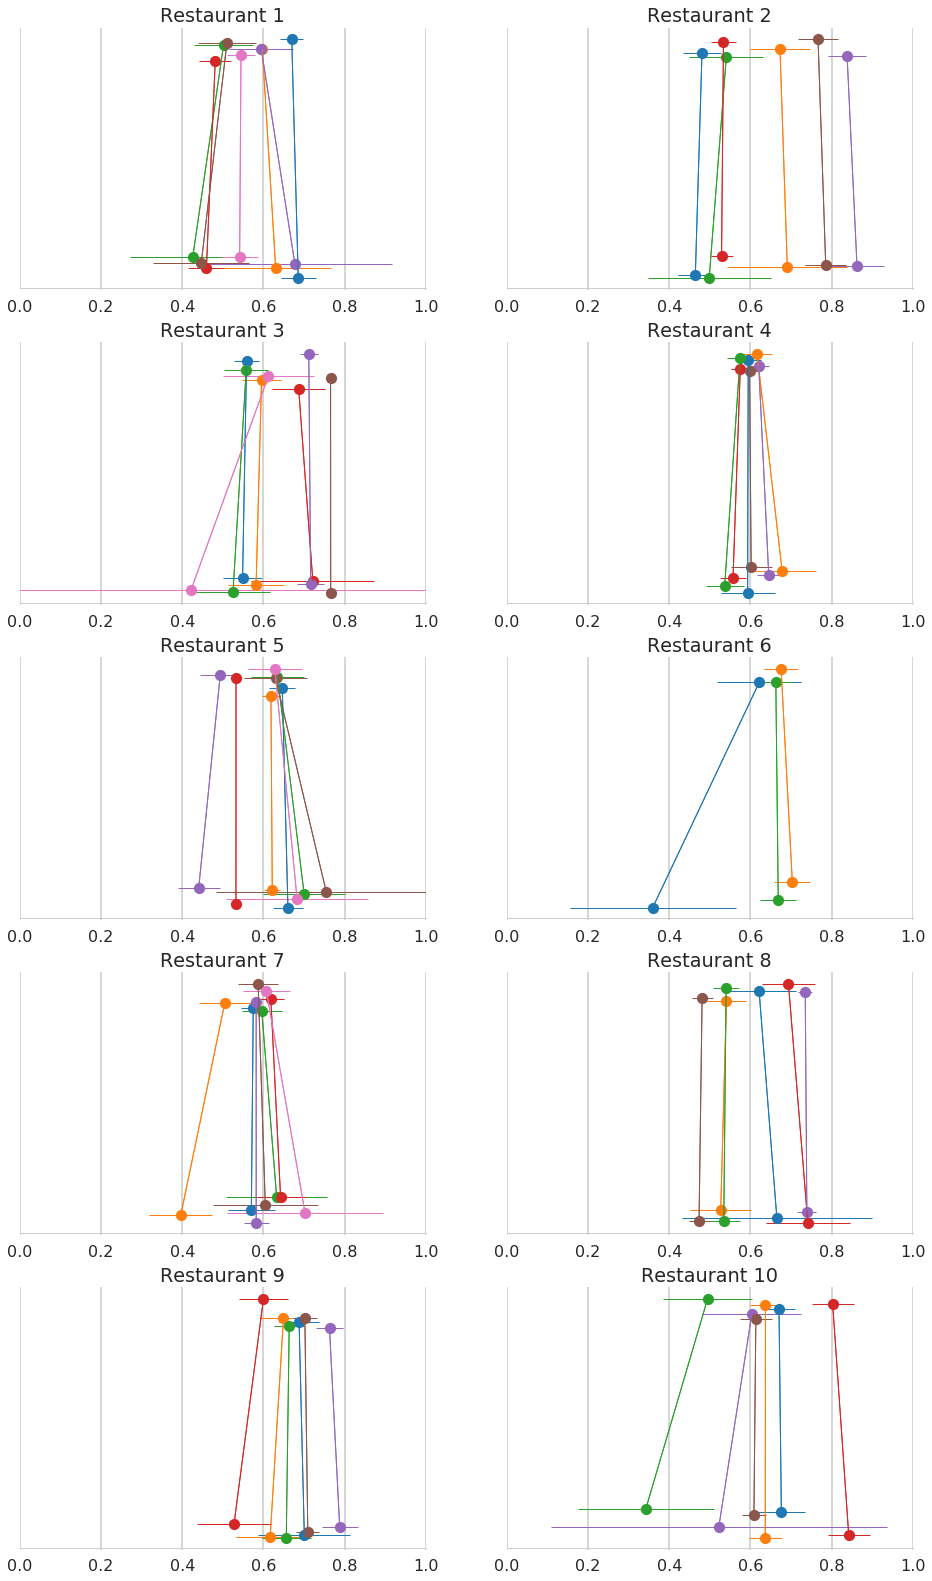

In [178]:
fig, axes = plt.subplots(5,2,figsize=(16,28))

for ax_id, ax_list in enumerate(axes):
    for ax_sub_id, ax in enumerate(ax_list):
        r_id = 2*ax_id + ax_sub_id
        rest_cur = restaurants[r_id][0]
        rt_cur = restaurant_traces[r_id][0]
        shrinkage_plot(rest_cur['y_obs'],np.mean(rt_cur['theta'],axis=0),np.square(rest_cur['sigma_obs'])*rest_cur['j_obs'],np.var(rt_cur['theta'],axis=0),rest_cur['count_obs'],ax)
        ax.set_title("Restaurant "+str(r_id+1))
    



#### Food Probability Shrinkage Plots

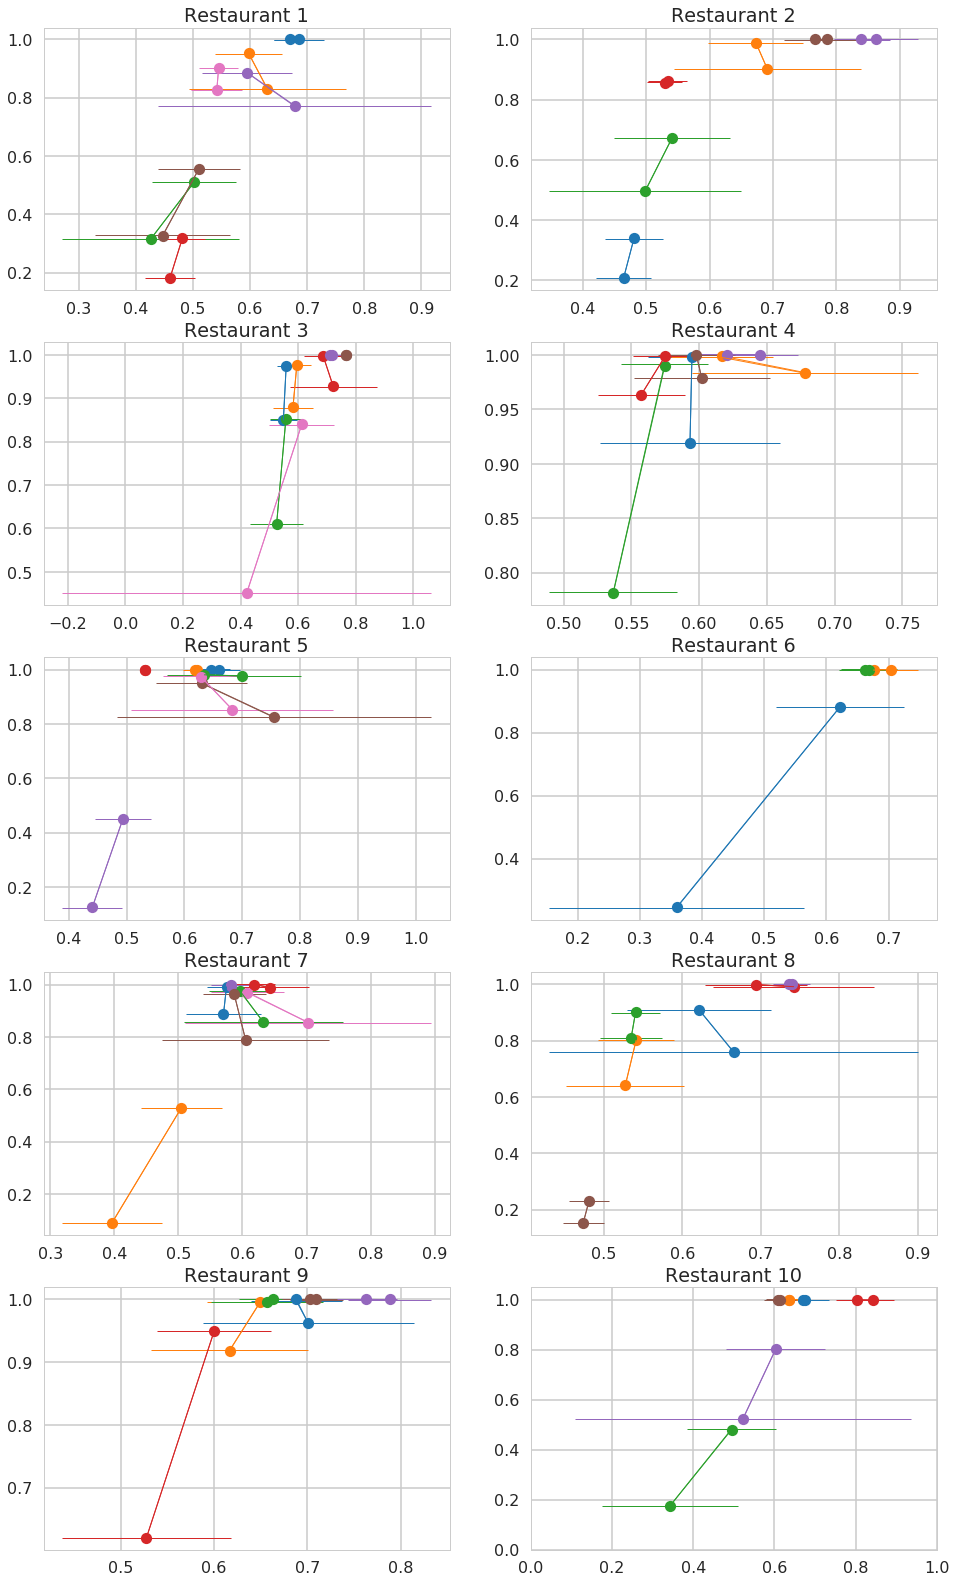

In [179]:
fig, axes = plt.subplots(5,2,figsize=(16,28))

for ax_id, ax_list in enumerate(axes):
    for ax_sub_id, ax in enumerate(ax_list):
        r_id = 2*ax_id + ax_sub_id
        rest_cur = restaurants[r_id][0]
        rt_cur = restaurant_traces[r_id][0]
        prob_shrinkage_plot(rest_cur['y_obs'],np.mean(rt_cur['theta'],axis=0),np.square(rest_cur['sigma_obs'])*rest_cur['j_obs'],np.var(rt_cur['theta'],axis=0),rest_cur['count_obs'],ax)
        ax.set_title("Restaurant "+str(r_id+1))
    



#### Service Shrinkage Plots

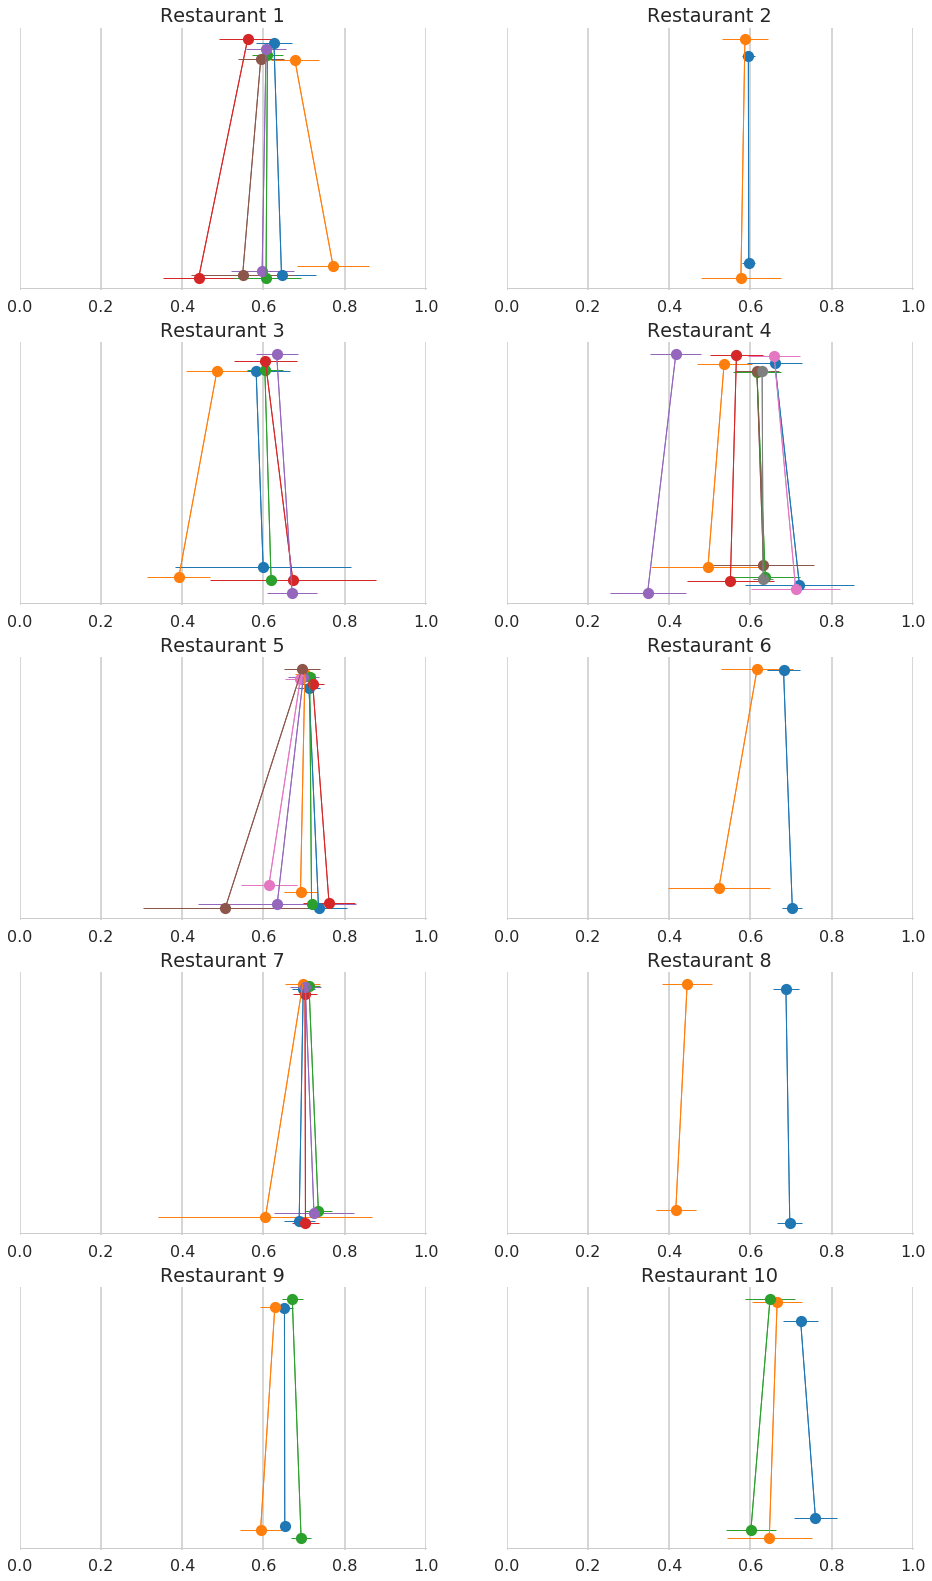

In [180]:
fig, axes = plt.subplots(5,2,figsize=(16,28))

for ax_id, ax_list in enumerate(axes):
    for ax_sub_id, ax in enumerate(ax_list):
        r_id = 2*ax_id + ax_sub_id
        rest_cur = restaurants[r_id][1]
        rt_cur = restaurant_traces[r_id][1]
        shrinkage_plot(rest_cur['y_obs'],np.mean(rt_cur['theta'],axis=0),np.square(rest_cur['sigma_obs'])*rest_cur['j_obs'],np.var(rt_cur['theta'],axis=0),rest_cur['count_obs'],ax)
        ax.set_title("Restaurant "+str(r_id+1))
    



#### Service Probability Shrinkage Plots

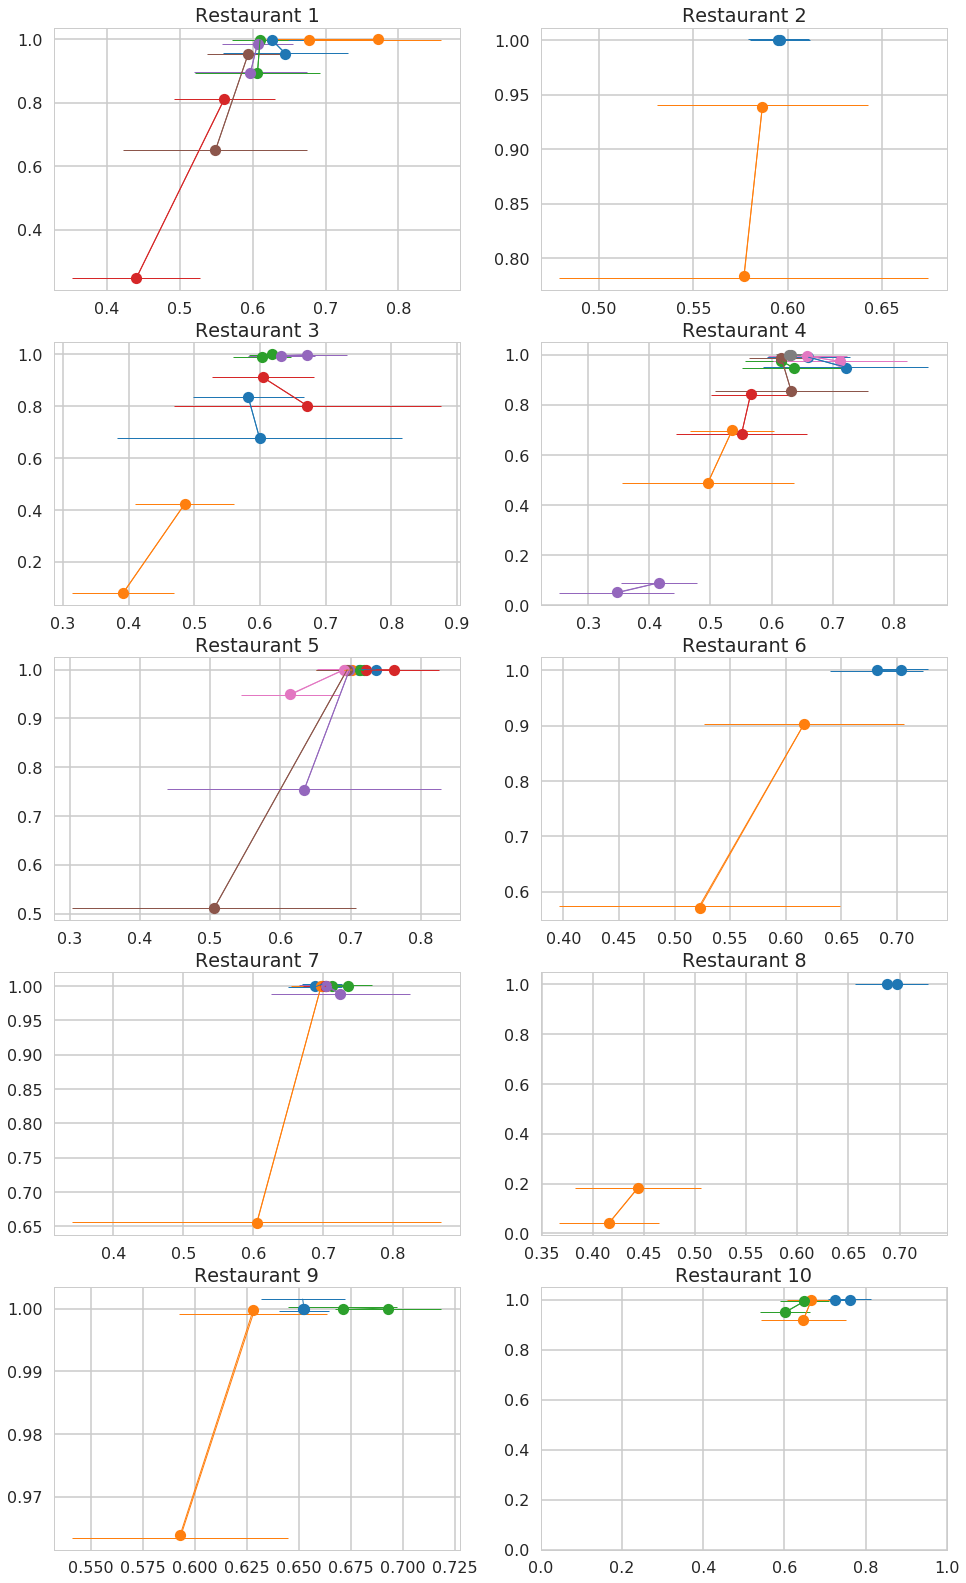

In [181]:
fig, axes = plt.subplots(5,2,figsize=(16,28))

for ax_id, ax_list in enumerate(axes):
    for ax_sub_id, ax in enumerate(ax_list):
        r_id = 2*ax_id + ax_sub_id
        rest_cur = restaurants[r_id][1]
        rt_cur = restaurant_traces[r_id][1]
        prob_shrinkage_plot(rest_cur['y_obs'],np.mean(rt_cur['theta'],axis=0),np.square(rest_cur['sigma_obs'])*rest_cur['j_obs'],np.var(rt_cur['theta'],axis=0),rest_cur['count_obs'],ax)
        ax.set_title("Restaurant "+str(r_id+1))
    



**Conclusion**:

In both the shrinkage plots and the probability shrinkage plots we see in action one of the main advantages of modeling reviewer postive sentiment hierarchically.  The pooling effect that's part and parcel of hierarchical models allows reviews with varying degrees of statistical potency  and in particular reviews a high degree of uncertainty (expressed as a high variance) to be moderated by other reviews with more sentences and thus less uncertainty in the conclusions of models based on them.

### Part C: Analysis Across Restaurants

Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. Discuss the statistical weakness of ranking by these scores.

(**Hint:** what is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? You've seen this question addressed a number of times in previous homeworks. This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)

**Solution**

A natural solution for ranking restaurants by food and service would be to average the posterior means for food and service each and use those as the basis for ranking.

In [198]:
food_scores = []
service_scores = []

for i, rest_trace in enumerate(restaurant_traces):
    food_scores.append((i, rest_trace[0]["theta"].mean()))
    service_scores.append((i, rest_trace[1]["theta"].mean()))

In [202]:
food_scores.sort(key=lambda x: x[1], reverse=True)
service_scores.sort(key=lambda x: x[1], reverse=True)

print("Restaurants ranked by food scores: ", [x[0] for x in food_scores])
print("Restaurants ranked by service scores: ", [x[0] for x in service_scores])


Restaurants ranked by food scores:  [8, 5, 2, 1, 9, 7, 4, 3, 6, 0]
Restaurants ranked by service scores:  [4, 6, 9, 8, 5, 0, 1, 3, 2, 7]


### Extra Credit:

1. Propose a model addressing the weakness of your approach in Part C for the overall quality of food and service for each restaurant given the $\theta$'s. Combine your model for the overall quality with your model for the $\theta$'s. 
2. Implement and use this combined model to estimate the overall quality of food and service for each restaurant.

(Its perfectly ok to just propose and not implement, you'll just get less credit. But please atleast try part 1!)